# Document Classifier

### Author: Erick Orozco

In [155]:
# general packages 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

# text preprocessing
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import spacy
import re

# general ML packages
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer

# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# multinomial naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, log_loss


# BERT
import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, RobertaTokenizer
from tensorflow.keras.optimizers import Adam, SGD

## Prep Text into Data Frames

In [84]:
# load and store data

filepath = '../data/labeled_data.csv'

df = pd.read_csv(filepath,index_col=0)

df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [85]:
# this exercise is purely an exercise of NLP, so we'll stick with only 'class' & tweet

og_df = df.copy()
df = df[['class','tweet']]
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Let's prep the data 

In [86]:
# general text preprocessing

#stop_words = set(stopwords.words('english'))
spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')
replace_space = re.compile('[/(){}\[\]\|@,;]')
replace_blank = re.compile('[^0-9a-z #+_]')


# input: unprocessed text
# output: processed text
def text_cleaner(txt):
    txt = txt.lower()
    txt = replace_space.sub(' ',txt)
    txt = replace_blank.sub('',txt)
    txt = ' '.join(item.text for item in nlp(txt) if not item.is_stop)
    return txt

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [87]:
# preprocess text
df['tweet'] = df['tweet'].apply(text_cleaner)

# split data train & test sets
x_train,x_test,y_train,y_test=train_test_split(df['tweet'],df['class'],test_size=0.20,\
                                               random_state=0,stratify=df['class'])

## Data Exploratory Analysis

Focuses:

- Check For Null Values
- View class imbalance of data
- 

In [75]:
# check total null values in every column
print(df.isnull().sum())

class    0
tweet    0
dtype: int64


In [99]:
# a separate df helpful for class visualizations 
classes = {0:'Hate Speech',1:'Offensive Language',2:'Neither'}

labeled_df = df.copy()
labeled_df['class'].replace(classes,inplace=True)
labeled_df

,class,tweet
0,Neither,rt mayasolovely woman nt complain cleaning...
1,Offensive Language,rt mleew17 boy dats coldtyga dwn bad cuffi...
2,Offensive Language,rt urkindofbrand dawg rt 80sbaby4life fu...
3,Offensive Language,rt c_g_anderson viva_based look like tranny
4,Offensive Language,rt shenikaroberts shit hear true faker bit...
...,...,...
25291,Offensive Language,yous muthafin lie # 8220 lifeasking 20_pea...
25292,Neither,ve gone broke wrong heart baby drove redneck...
25294,Offensive Language,young buck wanna eat dat nigguh like ai nt fuc...
25295,Offensive Language,youu got wild bitches tellin lies


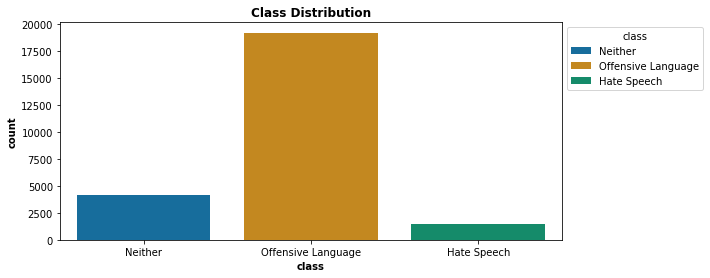

In [92]:
# visualization of label distribution
plt.figure(figsize=(9,4))
palette = sns.color_palette('colorblind')
chart = sns.countplot(x='class',data=labeled_df,hue='class',dodge=False,palette=palette)
chart.set_xlabel(chart.get_xlabel(), fontdict={'weight': 'bold'})
chart.set_ylabel(chart.get_ylabel(), fontdict={'weight': 'bold'})
chart.set_title('Class Distribution',fontdict={'weight': 'bold'})
sns.move_legend(chart, "upper left", bbox_to_anchor=(1, 1))

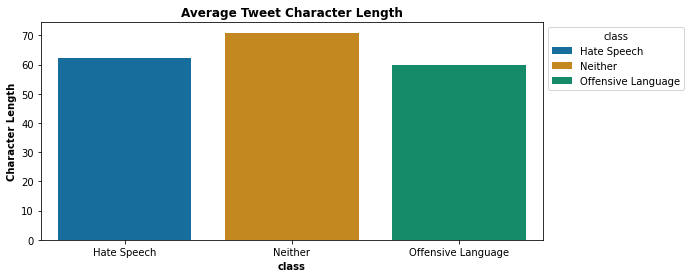

In [114]:
labeled_df['char_length'] = labeled_df['tweet'].str.len()
temp = labeled_df.groupby('class').mean()
temp.reset_index(inplace=True)
plt.figure(figsize=(9,4))
palette = sns.color_palette('colorblind')
chart = sns.barplot(x='class',y='char_length',data=temp,hue='class',dodge=False,palette=palette)
chart.set_xlabel(chart.get_xlabel(), fontdict={'weight': 'bold'})
chart.set_ylabel('Character Length', fontdict={'weight': 'bold'})
chart.set_title('Average Tweet Character Length',fontdict={'weight': 'bold'})
sns.move_legend(chart, "upper left", bbox_to_anchor=(1, 1))

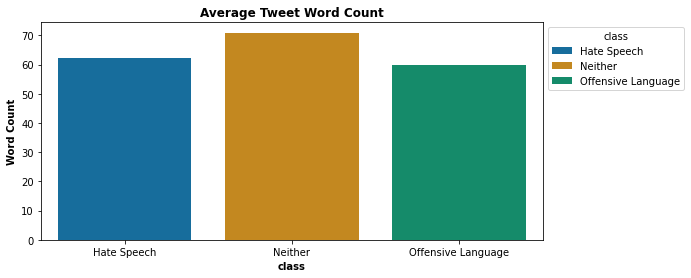

In [124]:
labeled_df['word_count'] = labeled_df['tweet'].str.split().str.len()
temp = labeled_df.groupby('class').mean()
labeled_df['char_length'] = labeled_df['tweet'].str.len()
temp = labeled_df.groupby('class').mean()
temp.reset_index(inplace=True)
plt.figure(figsize=(9,4))
palette = sns.color_palette('colorblind')
chart = sns.barplot(x='class',y='char_length',data=temp,hue='class',dodge=False,palette=palette)
chart.set_xlabel(chart.get_xlabel(), fontdict={'weight': 'bold'})
chart.set_ylabel('Word Count', fontdict={'weight': 'bold'})
chart.set_title('Average Tweet Word Count',fontdict={'weight': 'bold'})
sns.move_legend(chart, "upper left", bbox_to_anchor=(1, 1))

## TF-IDF


In [38]:
# tfidf vectors

vec = TfidfVectorizer()

## Multinomial Naive Bayes

In [39]:
# pipeline construction for multinomial naive bayes
nb_pipe = Pipeline([
    ('tf-idf', vec),
    ('clf', MultinomialNB()),
])

In [76]:
# standard multinomial naive bayes wiuth tf-idf (no cross validation)

nb_pipe.fit(x_train, y_train)

nb_train_pred = nb_pipe.predict(x_train)
nb_test_pred = nb_pipe.predict(x_test)


target_names = classes.values()
print('---------------Training Scores---------------\n')
print("Train Accuracy score: " + str(accuracy_score(y_train, nb_train_pred)))
print(print(classification_report(y_train, nb_train_pred, target_names=target_names)))

print('---------------Test Scores---------------\n')
print("Test Accuracy score: " + str(accuracy_score(y_test, nb_test_pred)))
print(print(classification_report(y_test, nb_test_pred, target_names=target_names)))

---------------Training Scores---------------

Train Accuracy score: 0.8299203066680118
                    precision    recall  f1-score   support

       Hate Speech       1.00      0.00      0.01      1144
Offensive Language       0.82      1.00      0.90     15352
           Neither       0.99      0.33      0.50      3330

          accuracy                           0.83     19826
         macro avg       0.94      0.44      0.47     19826
      weighted avg       0.86      0.83      0.78     19826

None
---------------Test Scores---------------

Test Accuracy score: 0.7930199717571111
                    precision    recall  f1-score   support

       Hate Speech       0.00      0.00      0.00       286
Offensive Language       0.79      1.00      0.88      3838
           Neither       0.95      0.12      0.21       833

          accuracy                           0.79      4957
         macro avg       0.58      0.37      0.36      4957
      weighted avg       0.77      0.79

### Not great, let's cross-validate

In [69]:
# Let's try to improve our model by cross validating

# different scorers to evaluate in gridsearch
f1_macro = make_scorer(f1_score , average='macro')
f1_micro = make_scorer(f1_score , average='micro')


parameters = {'clf__alpha': (0.3,0.2,0.1, 0.01, 0.001)}  

In [72]:
#Scoring = accuracy
nb_grid = GridSearchCV(nb_pipe, parameters,scoring=accuracy_score)

nb_grid.fit(x_train, y_train)
nbg_train_pred = nb_grid.predict(x_train)
nbg_test_pred = nb_grid.predict(x_test)


target_names = classes.values()
print('---------------Training Scores---------------\n')
print("Train Accuracy score: " + str(accuracy_score(y_train, nbg_train_pred))+'\n')
print(print(classification_report(y_train, nbg_train_pred, target_names=target_names)))

print('---------------Test Scores---------------\n')
print("Test Accuracy score: " + str(accuracy_score(y_test, nbg_test_pred))+'\n')
print(print(classification_report(y_test, nbg_test_pred, target_names=target_names)))


print('---------------Best Parameters---------------\n')
print(nb_grid.best_params_)

---------------Training Scores---------------

Train Accuracy score: 0.9127408453545849

                    precision    recall  f1-score   support

       Hate Speech       1.00      0.21      0.34      1144
Offensive Language       0.90      1.00      0.95     15352
           Neither       0.98      0.76      0.86      3330

          accuracy                           0.91     19826
         macro avg       0.96      0.65      0.72     19826
      weighted avg       0.92      0.91      0.90     19826

None
---------------Test Scores---------------

Test Accuracy score: 0.82812184789187

                    precision    recall  f1-score   support

       Hate Speech       0.00      0.00      0.00       286
Offensive Language       0.82      0.99      0.90      3838
           Neither       0.91      0.35      0.50       833

          accuracy                           0.83      4957
         macro avg       0.58      0.45      0.47      4957
      weighted avg       0.79      0.83

In [67]:
#Scoring = macro f1-score
nb_grid = GridSearchCV(nb_pipe, parameters,scoring=f1_macro)

nb_grid.fit(x_train, y_train)
nbg_train_pred = nb_grid.predict(x_train)
nbg_test_pred = nb_grid.predict(x_test)


target_names = classes.values()
print('---------------Training Scores---------------\n')
print("Train Accuracy score: " + str(accuracy_score(y_train, nbg_train_pred))+'\n')
print(print(classification_report(y_train, nbg_train_pred, target_names=target_names)))

print('---------------Test Scores---------------\n')
print("Test Accuracy score: " + str(accuracy_score(y_test, nbg_test_pred))+'\n')
print(print(classification_report(y_test, nbg_test_pred, target_names=target_names)))


print('---------------Best Parameters---------------\n')
print(nb_grid.best_params_)

---------------Training Scores---------------

Train Accuracy score: 0.9752345405023706

                    precision    recall  f1-score   support

       Hate Speech       0.97      0.80      0.88      1144
Offensive Language       0.97      1.00      0.98     15352
           Neither       0.99      0.93      0.96      3330

          accuracy                           0.98     19826
         macro avg       0.98      0.91      0.94     19826
      weighted avg       0.98      0.98      0.97     19826

None
---------------Test Scores---------------

Test Accuracy score: 0.8400242081904378

                    precision    recall  f1-score   support

       Hate Speech       0.33      0.09      0.14       286
Offensive Language       0.85      0.97      0.91      3838
           Neither       0.80      0.52      0.63       833

          accuracy                           0.84      4957
         macro avg       0.66      0.52      0.56      4957
      weighted avg       0.81      0.

In [71]:
#Scoring = micro f1-score
nb_grid = GridSearchCV(nb_pipe, parameters,scoring=f1_micro)

nb_grid.fit(x_train, y_train)
nbg_train_pred = nb_grid.predict(x_train)
nbg_test_pred = nb_grid.predict(x_test)


target_names = classes.values()
print('---------------Training Scores---------------\n')
print("Train Accuracy score: " + str(accuracy_score(y_train, nbg_train_pred))+'\n')
print(print(classification_report(y_train, nbg_train_pred, target_names=target_names)))

print('---------------Test Scores---------------\n')
print("Test Accuracy score: " + str(accuracy_score(y_test, nbg_test_pred))+'\n')
print(print(classification_report(y_test, nbg_test_pred, target_names=target_names)))


print('---------------Best Parameters---------------\n')
print(nb_grid.best_params_)

---------------Training Scores---------------

Train Accuracy score: 0.9544537476041561

                    precision    recall  f1-score   support

       Hate Speech       0.99      0.57      0.72      1144
Offensive Language       0.95      1.00      0.97     15352
           Neither       0.99      0.89      0.94      3330

          accuracy                           0.95     19826
         macro avg       0.97      0.82      0.88     19826
      weighted avg       0.96      0.95      0.95     19826

None
---------------Test Scores---------------

Test Accuracy score: 0.8442606415170466

                    precision    recall  f1-score   support

       Hate Speech       0.40      0.04      0.08       286
Offensive Language       0.85      0.98      0.91      3838
           Neither       0.86      0.48      0.61       833

          accuracy                           0.84      4957
         macro avg       0.70      0.50      0.53      4957
      weighted avg       0.82      0.

### Good improvement overall